In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
import theano.tensor as tt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]

In [2]:
az.style.use("arviz-darkgrid")


def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()

Import election results as well as city-level (`unemployment`) and district-level predictors (`csp_plus` and `pop2554`):

In [3]:
d = pd.read_csv("demo_results_and_preds.csv", index_col=0)
d

,arrondissement,date,ville,N,farleft,left,green,center,right,farright,other,type,unemployment,csp_plus,pop2554
0,1,2007-04-22,Paris,9152,239,2530,205,2051,3595,418,114,president,7.8,4886.163367,8915.091416
1,1,2007-06-10,Paris,6825,243,0,1969,818,3430,158,207,legislative,7.8,4886.163367,8915.091416
2,1,2008-03-09,Paris,6127,75,2289,439,531,2641,152,0,municipale,6.6,5042.215106,8845.308159
3,1,2009-06-07,Paris,5212,275,665,1493,419,1808,127,425,european,7.9,5121.184955,8967.554268
4,1,2010-03-14,Paris,4843,295,1077,1038,177,1758,261,237,regional,8.2,5126.709956,8886.736184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,20,2014-03-23,Paris,54966,5692,20502,5990,0,11467,4112,7203,municipale,8.7,32923.619569,90139.233180
236,20,2014-05-25,Paris,49075,4974,10575,9498,4218,5994,4584,9232,european,8.8,32923.619569,90139.233180
237,20,2015-12-06,Paris,49130,6100,18315,7348,0,8340,4977,4050,regional,8.7,33664.134135,89863.300140
238,20,2017-04-23,Paris,89574,28512,12469,0,27399,11451,5305,4438,president,8.0,34330.223246,90336.126337


Import poll aggregation for each election (city-level):

In [4]:
aggregated_polls = pd.read_csv("demo_aggregated_polls.csv", index_col=0)
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].div(100)

# replace 0 (i.e party not available) by very small values to avoid -inf when taking the log:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].replace(
    to_replace=0, value=aggregated_polls.green_agg.iloc[-2]
)

# revert the softmax:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].apply(np.log) + 1
aggregated_polls.round(2)

,type,dateelection,samplesize_agg,farleft_agg,left_agg,green_agg,center_agg,right_agg,farright_agg
0,president,2007-04-22,1513,-2.63,-0.43,-3.95,-0.67,-0.30,-0.95
1,legislatives,2007-06-10,916,-1.61,-0.29,-2.30,-1.20,0.12,-1.76
2,municipale,2008-03-09,755,-2.33,0.19,-1.85,-1.51,-0.12,-2.82
3,europeennes,2009-06-07,2287,-1.04,-0.63,-1.01,-1.19,-0.30,-1.85
4,regionales,2010-03-14,907,-1.32,-0.24,-1.00,-2.06,-0.24,-1.40
5,president,2012-04-22,1400,-0.99,-0.29,-2.68,-1.27,-0.32,-0.84
6,legislatives,2012-06-10,1193,-1.53,-0.14,-1.98,-2.58,-0.09,-0.88
7,municipale,2014-03-23,977,-1.88,0.04,-1.73,-22.24,-0.01,-1.50
8,europeennes,2014-05-25,3248,-1.58,-0.79,-1.42,-1.33,-0.54,-0.46
9,regionales,2015-12-06,1749,-1.94,-0.47,-1.84,-22.24,-0.27,-0.24


Define useful index variables for the model:

In [5]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

date_id, dates = d.date.factorize(sort=True)
Ndates = len(dates)

Nparties = len(PARTIES) - 1
N = d.N.values
R_obs = d[PARTIES].values

# which parties are available for choice ("other" always is):
parties_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values
parties_available

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

Isolate and standardize predictors:

In [6]:
polls = stdz(aggregated_polls[PARTIES_AGG]).values  # STANDARDIZE?
city_unemp = stdz(np.log(d.loc[d.arrondissement == 1, "unemployment"])).values[:, None]
district_preds = stdz(np.log(d[["csp_plus", "pop2554"]])).values

Define and run the model:

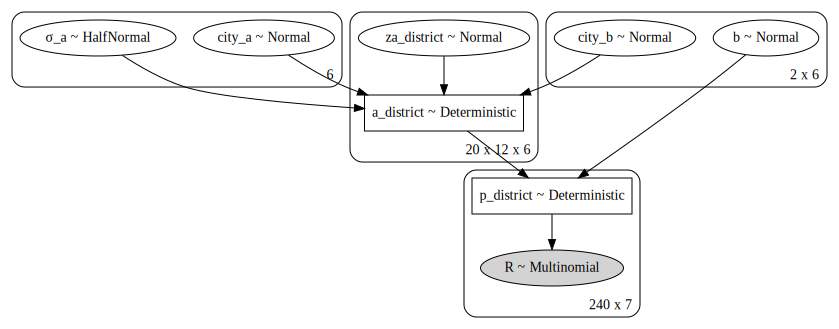

In [7]:
with pm.Model() as m_h_intercept_polls:
    city_a = pm.Normal("city_a", mu=-1.8, sigma=1.0, shape=Nparties)
    city_b = pm.Normal("city_b", mu=0.0, sigma=0.1, shape=(2, Nparties))
    σ_a = pm.HalfNormal("σ_a", 1.0, shape=Nparties)

    a = city_a + city_b[0] * city_unemp + city_b[1] * polls
    za_district = pm.Normal(
        f"za_district", 0.0, 1.0, shape=(Ndistricts, Ndates, Nparties)
    )
    a_district = pm.Deterministic(f"a_district", a + za_district * σ_a)
    b = pm.Normal("b", 0.0, 0.1, shape=(2, Nparties))

    # expected value per district:
    mu = a_district[district_id, date_id] + pm.math.dot(district_preds, b)
    # append last category:
    vary_pivot = tt.as_tensor_variable(
        np.full(shape=(Ndistricts, Ndates, 1), fill_value=-2.2)
    )
    mu = tt.horizontal_stack(mu, vary_pivot[district_id, date_id])

    # zero-inflation process:
    # keep only preferences for available parties:
    mu = parties_available * mu

    # preferences of each district, for all elections:
    p_district = pm.Deterministic("p_district", tt.nnet.softmax(mu))

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs)

pm.model_to_graphviz(m_h_intercept_polls)

In [8]:
with m_h_intercept_polls:
    m_h_intercept_polls_trace = pm.sample(
        1000, tune=6000, random_seed=RANDOM_SEED, target_accept=0.99, init="adapt_diag"
    )
az.summary(m_h_intercept_polls_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, za_district, σ_a, city_b, city_a]


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
city_a[0],-1.37,0.07,-1.50,-1.26,0.02,0.02,9.96,9.81,9.86,35.92,1.37
city_a[1],-0.09,0.14,-0.39,0.13,0.06,0.05,4.76,4.76,5.00,13.32,2.34
city_a[2],-1.21,0.10,-1.41,-1.04,0.04,0.03,5.67,5.67,6.00,35.64,1.79
city_a[3],-1.07,0.08,-1.21,-0.90,0.03,0.02,10.85,10.78,10.81,23.66,1.31
city_a[4],0.16,0.06,0.05,0.27,0.02,0.02,6.15,6.15,6.36,29.80,1.71
...,...,...,...,...,...,...,...,...,...,...,...
"p_district[239,2]",0.14,0.00,0.13,0.14,0.00,0.00,4343.86,4341.15,4332.82,3542.59,1.00
"p_district[239,3]",0.11,0.00,0.11,0.12,0.00,0.00,4086.74,4086.74,4081.71,3503.38,1.00
"p_district[239,4]",0.07,0.00,0.07,0.08,0.00,0.00,4631.34,4621.35,4650.47,2650.41,1.00
"p_district[239,5]",0.04,0.00,0.04,0.04,0.00,0.00,4551.08,4530.68,4572.46,2925.16,1.00


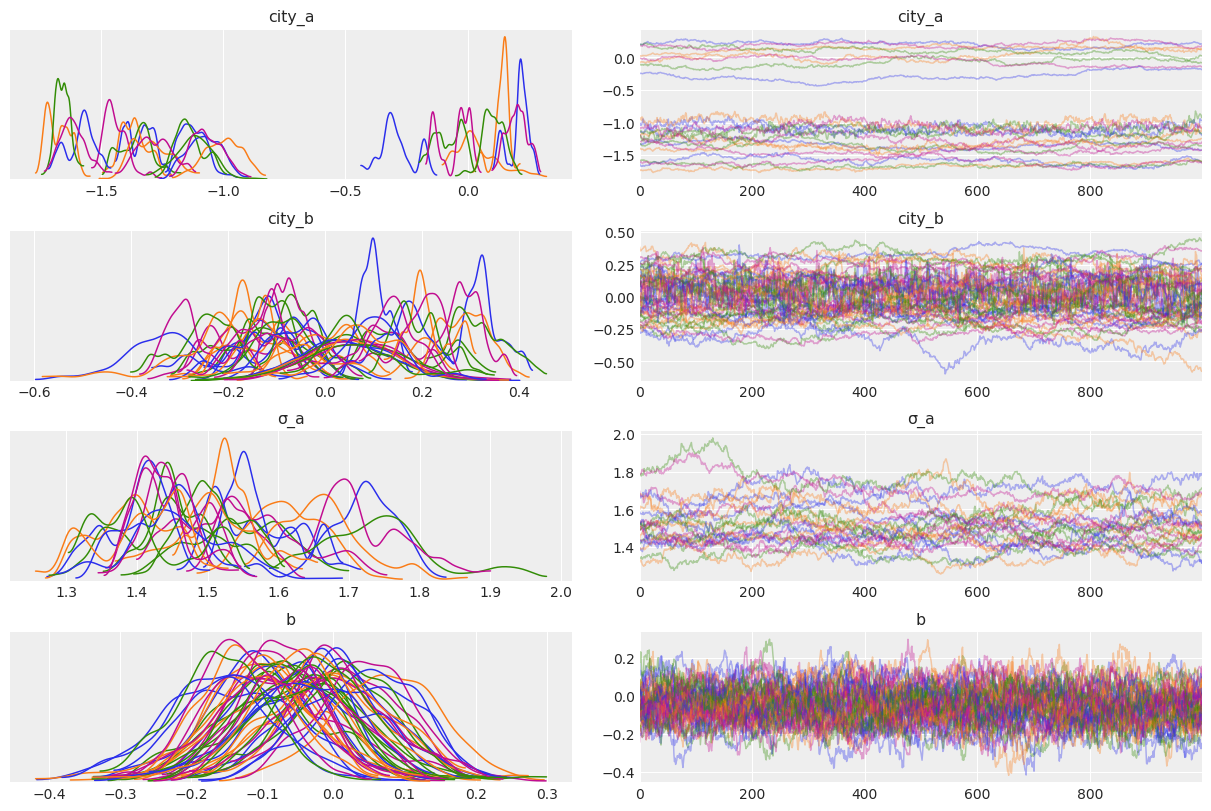

In [9]:
az.plot_trace(
    m_h_intercept_polls_trace, var_names=["city_a", "city_b", "σ_a", "b"], compact=True
);

In [33]:
csp_plus = stdz(np.log(d["csp_plus"])).values[:, None]
pop2554 = stdz(np.log(d["pop2554"])).values[:, None]

INFO (theano.gof.compilelock): Refreshing lock /Users/alex_andorra/.theano/compiledir_Darwin-19.2.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


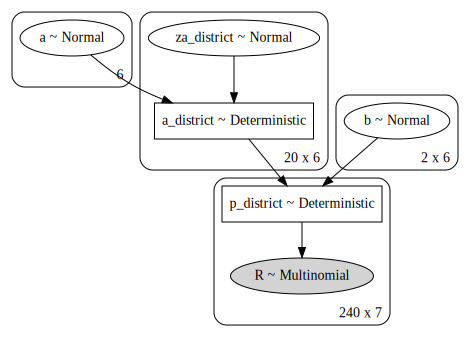

In [53]:
with pm.Model() as varying_intercepts:
    a = pm.Normal("a", -1.8, 1.0, shape=Nparties)
    σ_a = pm.HalfNormal("σ_a", 1.0, shape=Nparties)

    za_district = pm.Normal(f"za_district", 0.0, 1.0, shape=(Ndistricts, Nparties))
    a_district = pm.Deterministic(f"a_district", a + za_district * σ_a)
    b = pm.Normal("b", 0.0, 0.1, shape=(4, Nparties))

    # expected value per district:
    mu = (
        a_district[district_id]
        + b[0] * csp_plus
        + b[1] * pop2554
        + b[2] * city_unemp[date_id]
        + b[3] * polls[date_id]
    )
    # append last category:
    vary_pivot = tt.as_tensor_variable(
        np.full(shape=(Ndistricts, Ndates, 1), fill_value=-2.2)
    )
    mu = tt.horizontal_stack(mu, vary_pivot[district_id, date_id])

    # zero-inflation process:
    # keep only preferences for available parties:
    mu = parties_available * mu

    # preferences of each district, for all elections:
    p_district = pm.Deterministic("p_district", tt.nnet.softmax(mu))

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs)

pm.model_to_graphviz(varying_intercepts)

In [54]:
with varying_intercepts:
    varying_intercepts_trace = pm.sample(
        1000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.99, init="adapt_diag"
    )
az.summary(varying_intercepts_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, za_district, a]


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.10,0.23,-1.48,-0.83,0.10,0.08,5.02,4.72,6.71,16.24,1.65
a[1],0.21,0.16,-0.10,0.49,0.04,0.03,15.50,15.50,15.73,76.69,1.18
a[2],-2.11,0.18,-2.42,-1.70,0.05,0.03,15.62,15.28,15.41,55.26,1.19
a[3],-4.23,0.19,-4.53,-3.96,0.07,0.05,6.49,6.49,7.22,34.98,1.54
a[4],0.48,0.16,0.20,0.80,0.04,0.03,19.78,19.78,20.20,48.28,1.17
...,...,...,...,...,...,...,...,...,...,...,...
"p_district[239,2]",0.09,0.00,0.09,0.09,0.00,0.00,3001.79,3001.76,3004.70,3361.44,1.00
"p_district[239,3]",0.31,0.00,0.31,0.31,0.00,0.00,4078.47,4078.02,4092.61,3671.22,1.00
"p_district[239,4]",0.14,0.00,0.14,0.14,0.00,0.00,3651.67,3651.67,3637.65,3723.86,1.00
"p_district[239,5]",0.06,0.00,0.06,0.06,0.00,0.00,3990.76,3990.31,3991.48,3138.32,1.00


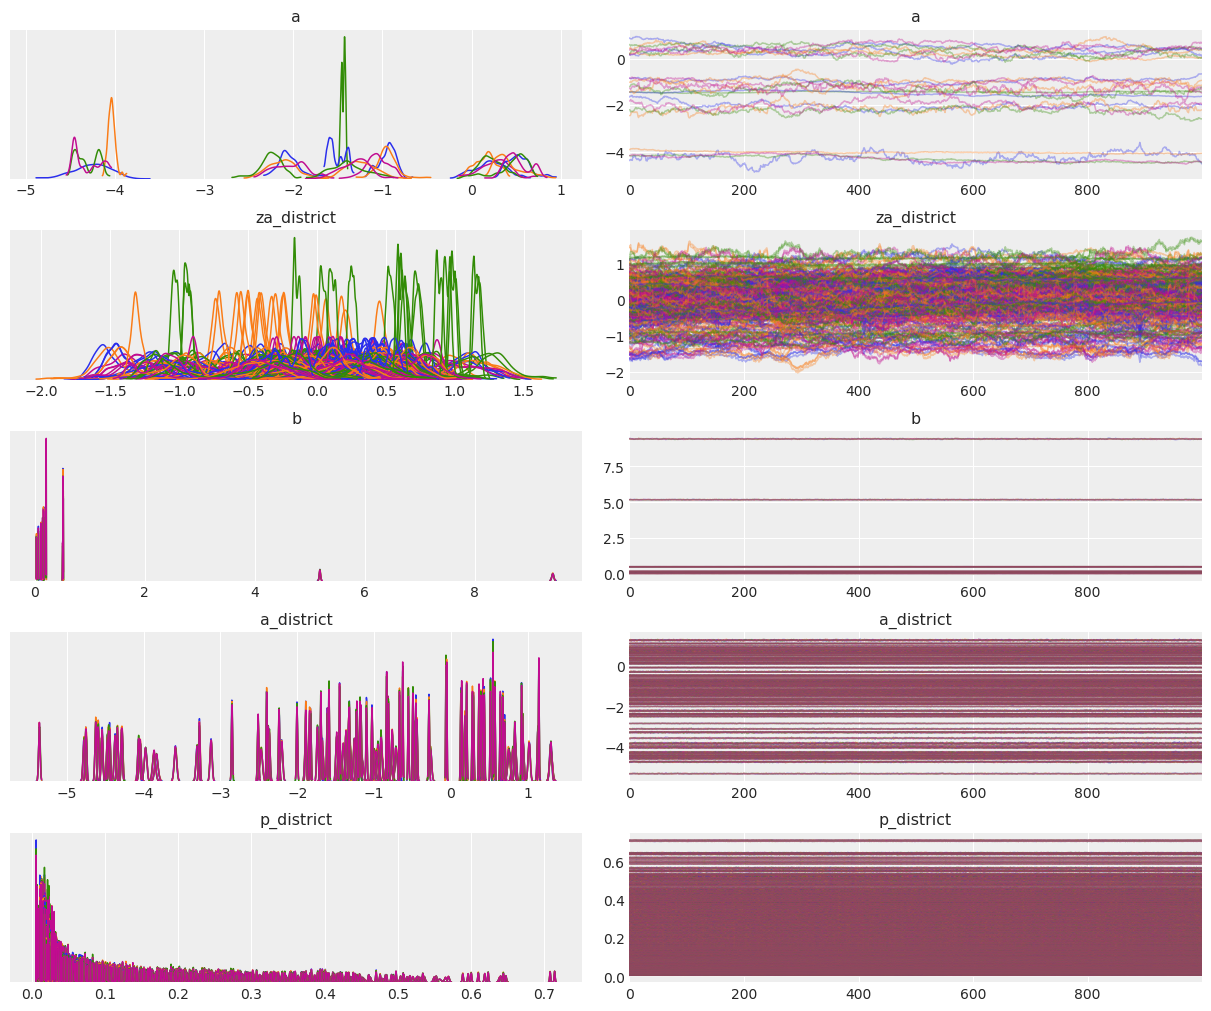

In [55]:
az.plot_trace(varying_intercepts_trace, compact=True);

In [8]:
# DO NOT RUN
%watermark -a AlexAndorra -n -u -v -iv

numpy  1.17.3
pandas 0.25.3
pymc3  3.8
arviz  0.6.1
AlexAndorra 
last updated: Thu Jan 30 2020 

CPython 3.7.5
IPython 7.9.0
